In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing, model_selection
import csv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import random

### Data Preparation

In [2]:
def get_dataset(directory, excluded_name=[]):
    data = pd.DataFrame(columns=['data', 'label'])
    for foldername in os.listdir(directory):        
        folder = os.path.join(directory, foldername)
        # print(folder)
        # print(os.listdir(folder))
        for name in os.listdir(folder):
            if name in excluded_name:
                # print(name)
                continue
            filename = os.path.join(folder, name)
            # print(filename)
            for files in os.listdir(filename):
                rel_path = os.path.join(filename, files)
                # print(rel_path)
                temp_label = folder
                if "autism" in temp_label:
                    label = 'autism'
                else:
                    label = 'normal'

                temp_data = pd.DataFrame(columns=['data', 'label'], index=[0])

                rwb = np.load(rel_path)
                rwb.astype(np.float64).reshape(-1,1)
                                
                temp_data.loc[0, "data"] = rwb
                temp_data['label'] = label
                data = pd.concat([data, temp_data], ignore_index=True)
    label_map = {"autism": 1, "normal": 0}
    data['label_map'] = data['label'].map(label_map)      
    return data

In [3]:
def remove_missing_value(data):
    series_list = np.vstack(data["data"].values)
    labels_list = data["label_map"].values    
    missing_indices = np.where(np.isnan(series_list).any(axis=1))[0]

    clean_data = data.drop(index=data.index[missing_indices])
    return clean_data

In [4]:
def log_transform(data):
    series_list = np.vstack(data["data"].values)
    labels_list = data["label_map"].values    

    epsilon = 1e-9  # To avoid log(0) issues
    log_transformed_series = np.log(series_list + epsilon)

    log_transformed_list = [arr for arr in log_transformed_series]
    data["data"] = log_transformed_list
    return data

In [5]:
# temp_data = pd.DataFrame(columns=['data', 'label'], index=[0])
# rwb = np.load("datasets/features/rwb/segment_1 seconds/autism_256/bader/Bader_segment_100.csv_bispectrum.npy")
# rwb.astype(np.float64).reshape(-1,1)
# temp_data.loc[0, "data"] = rwb
# temp_data['label'] = "autism"


In [6]:
def save_dataset(data, des_path):
    if not os.path.exists(des_path):
        os.makedirs(des_path)
    data.save(des_path)

In [7]:
def get_train_test(data, train_split: float):
    train_x, test_x, train_y, test_y = model_selection.train_test_split(
        data['data'],
        data[['label', 'label_map']],
        train_size=train_split,
        stratify=data['label_map']
    )

    train_df = pd.DataFrame(columns=['data', 'label', 'label_map'])
    test_df = pd.DataFrame(columns=['data', 'label', 'label_map'])

    train_df["data"] = train_x
    train_df[['label', 'label_map']] = train_y

    test_df["data"] = test_x
    test_df[['label', 'label_map']] = test_y

    return train_df, test_df

In [8]:
def get_batch(data):
    # loading extracted feature & label
    # x = get_dataset(path, lag, excluded_name)

    # scaler = preprocessing.MinMaxScaler()

    series_list = np.vstack(data["data"].values)

    # series_list = series_list.reshape(-1, 366, 1)

    labels_list = data["label_map"].values
        
    # y = keras.utils.to_categorical(y[0])
    dataset = tf.data.Dataset.from_tensor_slices((series_list,labels_list))
    dataset = dataset.shuffle(len(labels_list))

    # train_size = int(train_split * len(labels_list))  
    # test_size = len(labels_list) - train_size  

    # train_dataset = dataset.take(train_size)
    # test_dataset = dataset.skip(train_size)

    BATCH_SIZE = 32

    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [9]:
# train_x, test_x, train_y, test_y = model_selection.train_test_split(
#         data['data'],
#         data[['label', 'label_map']],
#         train_size=0.8,
#         stratify=data['label_map']
#     )

# train_df = pd.DataFrame(columns=['data', 'label', 'label_map'])
# test_df = pd.DataFrame(columns=['data', 'label', 'label_map'])

# train_df["data"] = train_x
# train_df[['label', 'label_map']] = train_y

# test_df["data"] = test_x
# test_df[['label', 'label_map']] = test_y

In [10]:
# excluded = ["zyad"]
# data = get_dataset(data_dir, 256, excluded_name=excluded)

In [11]:
# temp = data["data"].values
# series_list = np.vstack(temp)
# series_list = series_list.reshape(-1, 96, 1)

In [12]:
data_dir = "datasets/features/dwt/segment_1 seconds"

train_dir = "datasets/tf_batch/dwt/segment_1 seconds/train"
test_dir = "datasets/tf_batch/dwt/segment_1 seconds/test"

In [13]:
excluded = ["zyad"]
train_split = 0.8
# LAG = [256, 128, 64, 32, 16, 8, 4, 2]

# for lag in LAG:
data = get_dataset(data_dir, excluded)
print(data.shape)
data = remove_missing_value(data)
print(data.shape)
data = log_transform(data)
print(data.shape)
train_data, test_data = get_train_test(data, train_split)
print("train:", train_data.shape)
print("test:", test_data.shape)

train_batch = get_batch(train_data)
test_batch = get_batch(test_data)
tf.data.Dataset.save(train_batch, f"{train_dir}")
tf.data.Dataset.save(test_batch, f"{test_dir}")

(15434, 3)
(15434, 3)
(15434, 3)
train: (12347, 3)
test: (3087, 3)


### Exploratory Data Analysis

(96,)


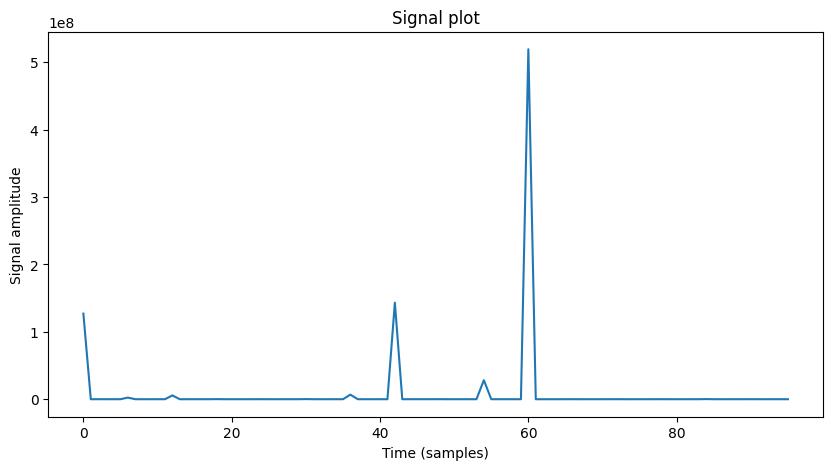

In [14]:
# Load the CSV file into a DataFrame
signal = np.load("datasets/features/dwt/segment_1 seconds/normal_/amer/Amer_segment_1003.csv_dwt.npy")

# Extract the signal values from the DataFrame

# Create a time axis for the signal
t = range(len(signal))
print(signal.shape)

fig, ax = plt.subplots(figsize=(10, 5))
# Plot the signal
ax.plot(t, signal)
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Signal amplitude')
ax.set_title('Signal plot')
plt.show()

### Model Definition

In [15]:
def create_model():
    model = keras.models.Sequential()

    model.add(layers.Input(shape=(96,)))
    model.add(layers.Reshape((96, 1)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation="relu"))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation="relu"))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model

### Define Callbacks

In [16]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='acc',
    patience=50,
    mode='max')
    model_path = os.path.join(log_dir,'best_model.h5')
    mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    return [tensorboard_callback, early_stopping, mc]
    

### Main Program

In [17]:
# lags = [256]
folds = ['train_1', 'test_1', 'epoch_1', 'train_2', 'test_2', 'epoch_2']
time_measured = ['Wall_Time_1', 'CPU_Time_1', 'Wall_Time_2', 'CPU_Time_2']
epochs = 2000
log_dirs = ['train_logs/logs6/DWT_ANN']

In [18]:
train_data = tf.data.Dataset.load(train_dir)
np.array(list(train_data.as_numpy_iterator())).shape

C:\Users\farra\AppData\Local\Temp\ipykernel_17876\2764964901.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(list(train_data.as_numpy_iterator())).shape


(386, 2)

In [19]:
for log_dir in log_dirs:
    recap = pd.DataFrame(columns=range(1, 6))
    training_time = pd.DataFrame(columns=[f'CPU_Time_{i}' for i in range(1, 6)] + [f'Wall_Time_{i}' for i in range(1, 6)])
    

    train_temp_dir = train_dir
    train = tf.data.Dataset.load(train_temp_dir)
    flattened_train = train.unbatch()
    
    train_data = list(flattened_train.as_numpy_iterator())
    train_size = len(train_data)
    # print(train_data[0].shape)
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    
    for fold, (train_index, val_index) in enumerate(kf.split(train_data), 1):
        train_fold_data = ([train_data[i][0] for i in train_index], [train_data[i][1] for i in train_index])
        val_fold_data = ([train_data[i][0] for i in val_index], [train_data[i][1] for i in val_index])
        
        train_fold = tf.data.Dataset.from_tensor_slices(train_fold_data).batch(16)
        val_fold = tf.data.Dataset.from_tensor_slices(val_fold_data).batch(16)
        
        log_path = os.path.join(log_dir, str(fold))
        
        model = create_model()
        model.summary()
        
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])
        
        cpu_start = time.process_time()
        wt_start = time.time()
        
        history = model.fit(train_fold, epochs=epochs, validation_data=val_fold, callbacks=myCallbacks(log_path))
        
        wt_end = time.time()
        cpu_end = time.process_time()
        wall_time = wt_end - wt_start
        cpu_time = cpu_end - cpu_start
        
        training_time.loc[f'CPU_Time_{fold}'] = cpu_time
        training_time.loc[f'Wall_Time_{fold}'] = wall_time
        
        recap.loc[fold] = history.history['acc'][-1]
    
    # Evaluate on the test dataset after cross-validation
    test_temp_dir = test_dir
    test_ds = tf.data.Dataset.load(test_temp_dir)
    results = model.evaluate(test_ds, callbacks=myCallbacks(log_path))
    
    recap[f'test'] = results[1]
    
    log_recap_dir = os.path.join(log_dir, 'Recap')
    if not os.path.exists(log_recap_dir):
        os.makedirs(log_recap_dir)
    
    recap.to_csv(os.path.join(log_recap_dir, 'recap.csv'))
    training_time.to_csv(os.path.join(log_recap_dir, 'Training_time.csv'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 1)             0         
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 512)               49664     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

## Model Testing

In [20]:
# Load Best Model
test_dir = "datasets/tf_batch/dwt/segment_1 seconds/test"
test_ds = tf.data.Dataset.load(test_dir)
model_dir = [f"train_logs/logs5/DWT_ANN/{i}/best_model.h5" for i in range(1,6)]

In [21]:
flattened_test = test_ds.unbatch()
test_data = list(flattened_test.as_numpy_iterator())

In [22]:
test_data_value = np.array([test_data[i][0] for i in range(len(test_data))])
test_data_label = np.array([test_data[i][1] for i in range(len(test_data))])

In [23]:
test_data_value.reshape(test_data_value.shape[0], -1).shape

(3087, 96)

In [24]:
results = []

for i, model_path in enumerate(model_dir):
    model = keras.models.load_model(model_path)
    loss, acc = model.evaluate(test_ds)
    print(loss, acc)
    pred = model.predict(test_data_value.reshape(test_data_value.shape[0], -1 ))
    results.append(pred)

97/97 [==============================] - 0s 1ms/step - loss: 0.5987 - acc: 0.6974
0.5986834168434143 0.6974408626556396
97/97 [==============================] - 0s 1ms/step - loss: 0.6051 - acc: 0.6981
0.6050844788551331 0.6980887651443481
97/97 [==============================] - 0s 1ms/step - loss: 0.5961 - acc: 0.6987
0.5960671901702881 0.6987366080284119
97/97 [==============================] - 0s 2ms/step - loss: 0.6000 - acc: 0.6978
0.6000260710716248 0.6977648138999939
97/97 [==============================] - 1s 2ms/step - loss: 0.5946 - acc: 0.6994
0.5945591926574707 0.6993845105171204
97/97 [==============================] - 0s 3ms/step


In [25]:
results[0].reshape(results[0].shape[0])

array([0.5555558 , 0.5712844 , 0.59311384, ..., 0.5987314 , 0.59132904,
       0.5922044 ], dtype=float32)

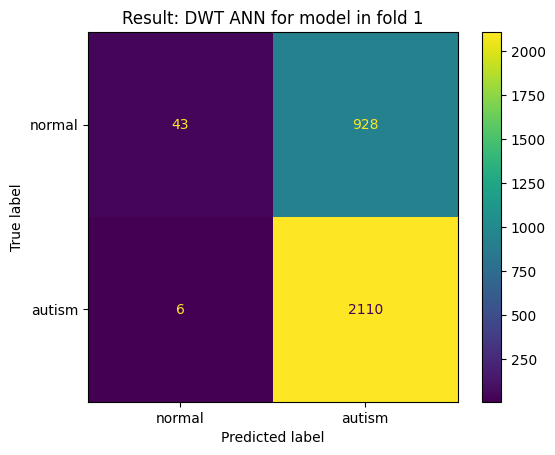

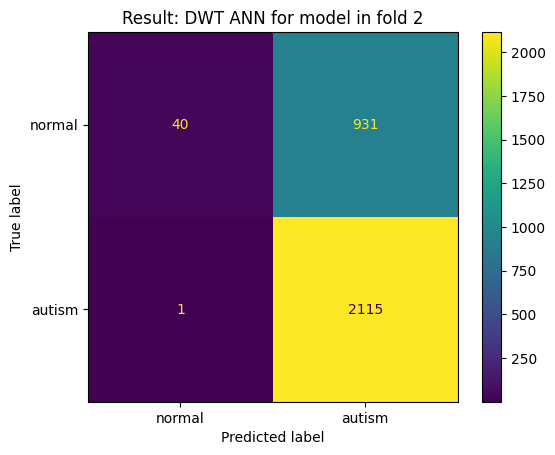

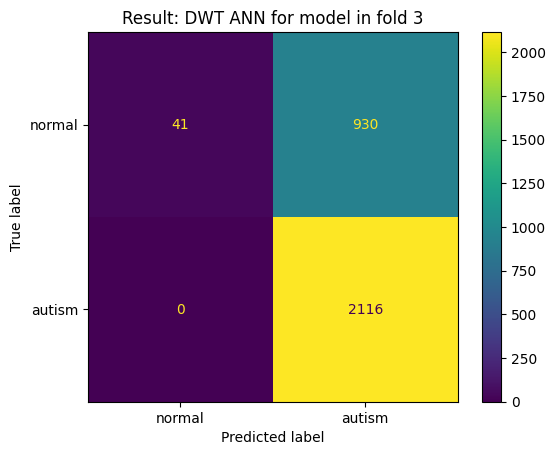

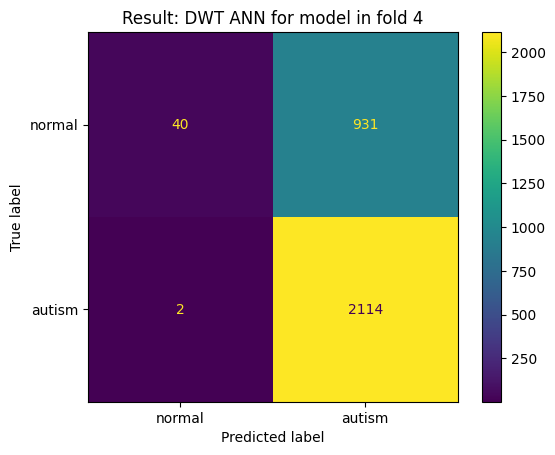

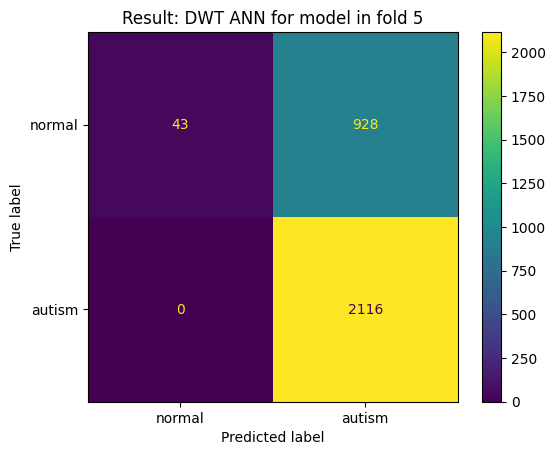

In [26]:
from sklearn import metrics

for i, res in enumerate(results, 1):
    pred = np.round(res.reshape(res.shape[0])).astype(bool)
    confusion_matrix = metrics.confusion_matrix(test_data_label, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'autism'])
    cm_display.plot()
    plt.title(f"Result: DWT ANN for model in fold {i}")
    plt.show()

In [27]:
for i, res in enumerate(results, 1):
    pred = np.round(res.reshape(res.shape[0])).astype(bool)
    test_data_label = test_data_label.astype(bool)  

    print(f"Result: DWT ANN for model in fold {i}")

    TP = np.sum((test_data_label == True) & (pred == True))
    FP = np.sum((test_data_label == False) & (pred == True))
    TN = np.sum((test_data_label == False) & (pred == False))
    FN = np.sum((test_data_label == True) & (pred == False))  

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {f1_score}")
    print("\n")

Result: DWT ANN for model in fold 1
Precision: 0.6945358788676761
Recall: 0.997164461247637
Accuracy: 0.6974408811143505
F1-score: 0.8187815289095848


Result: DWT ANN for model in fold 2
Precision: 0.6943532501641497
Recall: 0.9995274102079396
Accuracy: 0.6980887593132491
F1-score: 0.8194498256489733


Result: DWT ANN for model in fold 3
Precision: 0.6946815495732108
Recall: 1.0
Accuracy: 0.6987366375121478
F1-score: 0.8198372723750484


Result: DWT ANN for model in fold 4
Precision: 0.6942528735632184
Recall: 0.999054820415879
Accuracy: 0.6977648202137998
F1-score: 0.8192210811858167


Result: DWT ANN for model in fold 5
Precision: 0.695137976346912
Recall: 1.0
Accuracy: 0.6993845157110463
F1-score: 0.8201550387596899




In [28]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# for i, res in enumerate(results, 1):
#     pred = np.round(res.reshape(res.shape[0])).astype(bool)

#     print(f"Result: FFT ANN for model in fold {i}")
#     # Calculate accuracy
#     accuracy = accuracy_score(test_data_label, pred)
#     print("Accuracy:", accuracy)

#     # Calculate precision
#     precision = precision_score(test_data_label, pred)
#     print("Precision:", precision)

#     # Calculate recall (sensitivity)
#     recall = recall_score(test_data_label, pred)
#     print("Recall (Sensitivity):", recall)

#     # Calculate F1-score
#     f1 = f1_score(test_data_label, pred)
#     print("F1-Score:", f1)
#     print("\n")

In [29]:
# for log_dir in log_dirs:
#     recap = pd.DataFrame(index=lags, columns=folds)
#     training_time = pd.DataFrame(index=lags, columns=time_measured)
#     for fold in range(1,3):
#         for lag in lags:
#             if fold == 2:
#                 train_dir, test_dir = test_dir, train_dir
            
#             train_temp_dir = train_dir + '_' + str(lag)
#             test_temp_dir = test_dir + '_' + str(lag)

#             train = tf.data.Dataset.load(train_temp_dir)
#             test_ds = tf.data.Dataset.load(test_temp_dir)

#             train_size = int(len(list(train.as_numpy_iterator()))*0.8)
#             train_ds = train.take(train_size)
#             val_ds = train.skip(train_size)

#             log_path = os.path.join(log_dir, str(fold), str(lag))

#             model = create_model()
#             model.summary()

#             model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

#             cpu_start = time.process_time()
#             wt_start = time.time()

#             history = model.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks = myCallbacks(log_path))

#             wt_end = time.time()
#             cpu_end = time.process_time()
#             wall_time = wt_end - wt_start
#             cpu_time = cpu_end - cpu_start
#             training_time.loc[lag, 'CPU_Time'+ '_' + str(fold)] = cpu_time
#             training_time.loc[lag, 'Wall_Time'+ '_' + str(fold)] = wall_time

#             results = model.evaluate(test_ds, callbacks = myCallbacks(log_path))

#             recap.loc[lag, 'train'+ '_' + str(fold)] = history.history['acc']
#             recap.loc[lag, 'test'+ '_' + str(fold)] = results[1]
#             recap.loc[lag, 'epoch'+ '_' + str(fold)] = len(history.history['acc'])
#     log_dir = os.path.join(log_dir,'Recap')
#     if not os.path.exists(log_dir):
#         os.makedirs(log_dir)
#     recap.to_csv(os.path.join(log_dir,'recap.csv'))
#     training_time.to_csv(os.path.join(log_dir,'Training_time.csv'))

In [30]:
# for log_dir in log_dirs:
#     recap = pd.DataFrame(index=lags, columns=folds)
#     training_time = pd.DataFrame(index=lags, columns=time_measured)
#     for fold in range(1,3):
#         for lag in lags:
#             if fold == 2:
#                 train_dir, test_dir = test_dir, train_dir
            
#             train_temp_dir = train_dir + '_' + str(lag)
#             test_temp_dir = test_dir + '_' + str(lag)

#             train = get_batch(train_temp_dir)
#             test_ds = get_batch(test_temp_dir)

#             train_size = int(len(list(train.as_numpy_iterator()))*0.8)
#             train_ds = train.take(train_size)
#             val_ds = train.skip(train_size)

#             log_path = os.path.join(log_dir, str(fold), str(lag))

#             model = create_model()
#             model.summary()

#             model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

#             cpu_start = time.process_time()
#             wt_start = time.time()

#             history = model.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks = myCallbacks(log_path))

#             wt_end = time.time()
#             cpu_end = time.process_time()
#             wall_time = wt_end - wt_start
#             cpu_time = cpu_end - cpu_start
#             training_time.loc[lag, 'CPU_Time'+ '_' + str(fold)] = cpu_time
#             training_time.loc[lag, 'Wall_Time'+ '_' + str(fold)] = wall_time

#             results = model.evaluate(test_ds, callbacks = myCallbacks(log_path))

#             recap.loc[lag, 'train'+ '_' + str(fold)] = history.history['acc']
#             recap.loc[lag, 'test'+ '_' + str(fold)] = results[1]
#             recap.loc[lag, 'epoch'+ '_' + str(fold)] = len(history.history['acc'])
#     log_dir = os.path.join(log_dir,'Recap')
#     if not os.path.exists(log_dir):
#         os.makedirs(log_dir)
#     recap.to_csv(os.path.join(log_dir,'recap.csv'))
#     training_time.to_csv(os.path.join(log_dir,'Training_time.csv'))

In [31]:
# %load_ext tensorboard

In [32]:
# ! tensorboard --logdir c:/Users/farra/Documents/Pribadi/EEG/EEG-Autism-Classification --port=8000

In [33]:
# %tensorboard --logdir logs --port=8000

In [34]:
! cd

c:\Users\farra\Documents\Pribadi\EEG\EEG-Autism-Classification
